In [391]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision import datasets
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

device=torch.device("cuda:0")

# Import topnet utilities
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
import topnet
import importlib

3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
1.3.1


In [230]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'

data = datasets.MNIST(datadir+"original/", download=False,
                      transform= transforms.Compose([transforms.ToTensor()]))

In [303]:
data_X = torch.tensor([np.array(i[0]) for i in data])
n = np.arange(data_X.size()[0])
np.random.shuffle(n)
data_X = data_X[n]

In [498]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
                        
        x= torch.randn(28,28,1).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def convs(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))  
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]           
        return x
    
    def forward(self, x):
        h = self.convs(x)
        h = h.view(-1,self._to_linear)
        h = F.dropout(F.relu(self.fc1(h)),.2)
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out
    
# class Discriminator(torch.nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
        
#         self.fc1 = nn.Linear(28**2, 128)
#         self.fc2 = nn.Linear(128, 1)
        
    
#     def forward(self, x):
#         h = x.view(-1,28**2)
#         h = F.dropout(F.relu(self.fc1(h)),.2)
#         out = self.fc2(h)
#         out = torch.sigmoid(out)
#         return out    
    
    
    
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 40**2)
        self.conv1 = nn.Conv2d(1,128,5)
        self.conv2 = nn.Conv2d(128,64,5)        
        self.conv3 = nn.Conv2d(64,1,5)
        
    def forward(self, x):
        h = F.dropout(F.relu(self.fc1(x)),.2)
        # convert to image 
        h = h.view(-1, 1, 40, 40)
        h = F.leaky_relu(self.conv1(h),.2)
        h = F.leaky_relu(self.conv2(h),.2)
        h = self.conv3(h)
#         h = h.view(-1, 1, 28, 28)
        out = torch.tanh(h)
        return out

In [455]:
batchSize = 64
noiseDim = 100

D = Discriminator().to(device)
G = Generator().to(device)
optimizerD = torch.optim.Adam(D.parameters(), lr=1e-3)
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-3)
lab_real = torch.ones(batchSize, 1, device=device)
lab_fake = torch.zeros(batchSize, 1, device=device)

# for logging:
collect_x_gen = []
fixed_noise = torch.randn(batchSize, noiseDim, device=device)

for epoch in range(3): # 10 epochs
    for i in range(0, data_X.size()[0], batchSize):
        
        # STEP 1: Discriminator optimization step
        x_real = data_X[i:(i+batchSize),...].to(device)        
        optimizerD.zero_grad()
        
        lab_real = torch.ones(x_real.size()[0], 1, device=device)
        lab_fake = torch.zeros(x_real.size()[0], 1, device=device)

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(lab_fake.size()[0], noiseDim, device=device)
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)        

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        optimizerG.zero_grad()

        z = torch.randn(lab_fake.size()[0], noiseDim, device=device)
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)

        lossG.backward()
        optimizerG.step()
        if i % 30000 == 0:
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(data_X), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

RuntimeError: Given groups=1, weight of size 1 64 5 5, expected input[64, 32, 31, 31] to have 64 channels, but got 32 channels instead

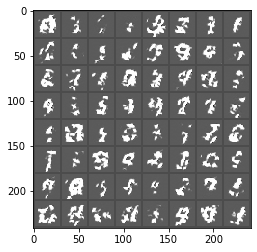

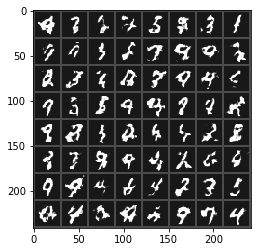

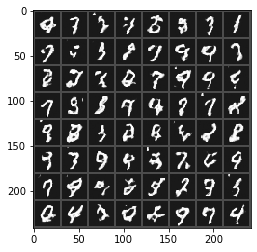

In [433]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

# Version w/ circle features as weights

In [591]:
grids = topnet.primary_circle(3,32)
# grids = topnet.legendre_klein_bottle(8,8,3)
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,128,3)
        self.conv3 = nn.Conv2d(128,128,3)
                        
        x= torch.randn(28,28,1).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def convs(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))  
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]           
        return x
    
    def forward(self, x):
        h = self.convs(x)
        h = h.view(-1,self._to_linear)
        h = F.dropout(F.relu(self.fc1(h)),.2)
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out      
        
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 36**2)
        self.conv1 = nn.Conv2d(1,512,3)
        self.conv2 = nn.Conv2d(512,64,3)
        self.conv3 = nn.Conv2d(64,32,3)
        self.conv4 = nn.Conv2d(32,1,3)
        
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x))
        # convert to image 
        h = h.view(-1, 1, 36, 36)
        h = F.leaky_relu(self.conv1(h))
        h = F.leaky_relu(self.conv2(h))
        h = F.leaky_relu(self.conv3(h))
        h = self.conv4(h)
#         h = h.view(-1, 1, 28, 28)
        out = torch.tanh(h)
        return out

In [599]:
batchSize = 100
noiseDim = 100

D = Discriminator().to(device)
G = Generator().to(device)
optimizerD = torch.optim.Adam(D.parameters(), lr=2e-4)
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4)

with torch.no_grad():
    for i,x in enumerate(grids):
        G.conv4.weight[0,i,:,:] = torch.nn.Parameter(torch.tensor(x)).to(device)
    G.conv3.requires_grad = False

    for i,x in enumerate(grids):
        D.conv1.weight[i,...] = torch.nn.Parameter(torch.tensor(x)).to(device)
    D.conv1.requires_grad = False
        
        
# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, noiseDim, device=device)

for epoch in range(10): # 10 epochs
    for i in range(0, data_X.size()[0], batchSize):
        
        # STEP 1: Discriminator optimization step
        x_real = data_X[i:(i+batchSize),...].to(device)        
        optimizerD.zero_grad()
        
        lab_real = torch.ones(x_real.size()[0], 1, device=device)
        lab_fake = torch.zeros(x_real.size()[0], 1, device=device)

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(lab_fake.size()[0], noiseDim, device=device)
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)        

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        optimizerG.zero_grad()

        z = torch.randn(lab_fake.size()[0], noiseDim, device=device)
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)

        lossG.backward()
        optimizerG.step()
        if i % 20000 == 0:
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(data_X), D_x.mean().item(), D_G_z.mean().item()))
            x_gen = G(fixed_noise)
            collect_x_gen.append(x_gen.detach().clone())


e0.i0/60000 last mb D(x)=0.4942 D(G(z))=0.5256
e0.i20000/60000 last mb D(x)=0.6390 D(G(z))=0.0612
e0.i40000/60000 last mb D(x)=0.9746 D(G(z))=0.0666
e1.i0/60000 last mb D(x)=0.9188 D(G(z))=0.0729
e1.i20000/60000 last mb D(x)=0.9360 D(G(z))=0.0406
e1.i40000/60000 last mb D(x)=0.9844 D(G(z))=0.0821
e2.i0/60000 last mb D(x)=0.8442 D(G(z))=0.0520
e2.i20000/60000 last mb D(x)=0.9699 D(G(z))=0.0555
e2.i40000/60000 last mb D(x)=0.9761 D(G(z))=0.1469
e3.i0/60000 last mb D(x)=0.9125 D(G(z))=0.1802
e3.i20000/60000 last mb D(x)=0.9367 D(G(z))=0.0499
e3.i40000/60000 last mb D(x)=0.9822 D(G(z))=0.0493
e4.i0/60000 last mb D(x)=0.8975 D(G(z))=0.0730
e4.i20000/60000 last mb D(x)=0.9817 D(G(z))=0.0205
e4.i40000/60000 last mb D(x)=0.9744 D(G(z))=0.1704
e5.i0/60000 last mb D(x)=0.9288 D(G(z))=0.0799
e5.i20000/60000 last mb D(x)=0.9427 D(G(z))=0.0441
e5.i40000/60000 last mb D(x)=0.9325 D(G(z))=0.1205
e6.i0/60000 last mb D(x)=0.8856 D(G(z))=0.0820
e6.i20000/60000 last mb D(x)=0.9396 D(G(z))=0.0279
e6.i4000

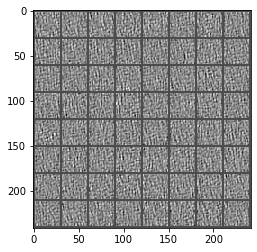

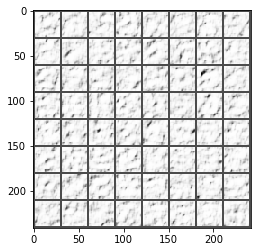

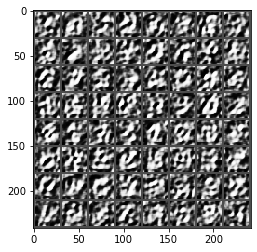

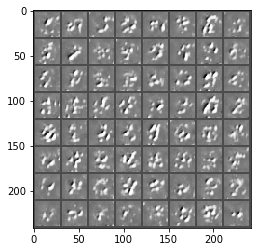

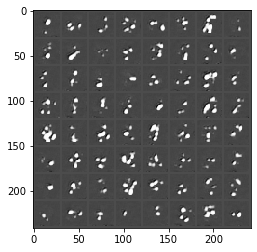

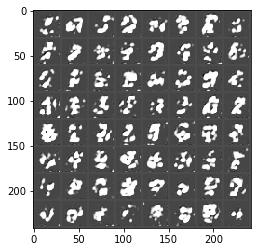

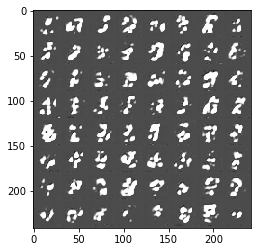

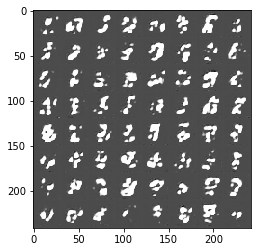

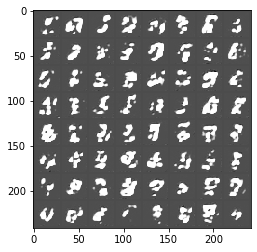

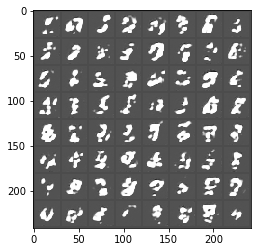

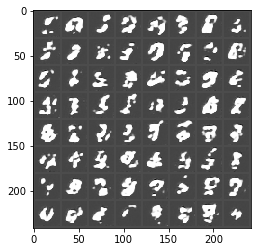

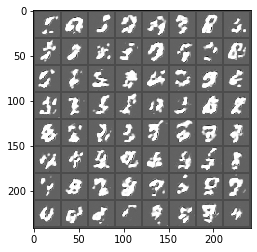

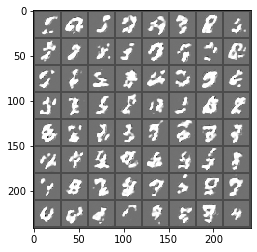

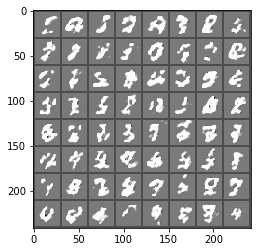

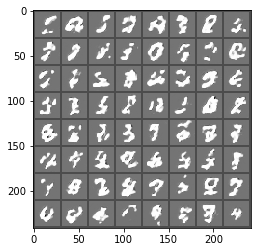

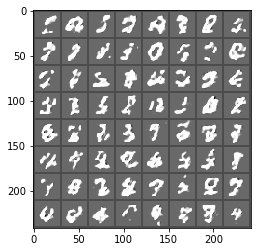

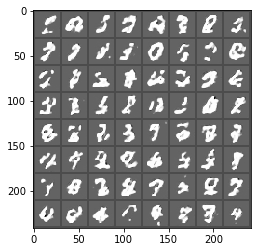

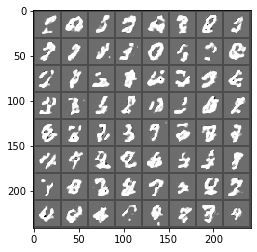

In [598]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

In [566]:
batchSize = 100
noiseDim = 100

D = Discriminator().to(device)
G = Generator().to(device)
optimizerD = torch.optim.Adam(D.parameters(), lr=2e-4)
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4)

# with torch.no_grad():
#     for i,x in enumerate(grids):
#         G.conv4.weight[0,i,:,:] = torch.nn.Parameter(torch.tensor(x)).to(device)
#     G.conv3.requires_grad = False

#     for i,x in enumerate(grids):
#         D.conv1.weight[i,...] = torch.nn.Parameter(torch.tensor(x)).to(device)
#     D.conv1.requires_grad = False
        
        
# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, noiseDim, device=device)

for epoch in range(10): # 10 epochs
    for i in range(0, data_X.size()[0], batchSize):
        
        # STEP 1: Discriminator optimization step
        x_real = data_X[i:(i+batchSize),...].to(device)        
        optimizerD.zero_grad()
        
        lab_real = torch.ones(x_real.size()[0], 1, device=device)
        lab_fake = torch.zeros(x_real.size()[0], 1, device=device)

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(lab_fake.size()[0], noiseDim, device=device)
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)        

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        optimizerG.zero_grad()

        z = torch.randn(lab_fake.size()[0], noiseDim, device=device)
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)

        lossG.backward()
        optimizerG.step()
        if i % 10000 == 0:
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(data_X), D_x.mean().item(), D_G_z.mean().item()))
            x_gen = G(fixed_noise)
            collect_x_gen.append(x_gen.detach().clone())


e0.i0/60000 last mb D(x)=0.4869 D(G(z))=0.5735
e0.i10000/60000 last mb D(x)=0.9962 D(G(z))=0.0309
e0.i20000/60000 last mb D(x)=0.6006 D(G(z))=0.2357
e0.i30000/60000 last mb D(x)=0.7117 D(G(z))=0.3779
e0.i40000/60000 last mb D(x)=0.8520 D(G(z))=0.2532
e0.i50000/60000 last mb D(x)=0.8861 D(G(z))=0.1702
e1.i0/60000 last mb D(x)=0.8152 D(G(z))=0.1266
e1.i10000/60000 last mb D(x)=0.8838 D(G(z))=0.1326
e1.i20000/60000 last mb D(x)=0.8355 D(G(z))=0.1456
e1.i30000/60000 last mb D(x)=0.8470 D(G(z))=0.0659
e1.i40000/60000 last mb D(x)=0.9038 D(G(z))=0.1370
e1.i50000/60000 last mb D(x)=0.9070 D(G(z))=0.1001
e2.i0/60000 last mb D(x)=0.8640 D(G(z))=0.0861
e2.i10000/60000 last mb D(x)=0.8672 D(G(z))=0.0962
e2.i20000/60000 last mb D(x)=0.9206 D(G(z))=0.1118
e2.i30000/60000 last mb D(x)=0.8634 D(G(z))=0.1900
e2.i40000/60000 last mb D(x)=0.9186 D(G(z))=0.2011
e2.i50000/60000 last mb D(x)=0.8550 D(G(z))=0.1469
e3.i0/60000 last mb D(x)=0.8785 D(G(z))=0.1484
e3.i10000/60000 last mb D(x)=0.9120 D(G(z))=0.1

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


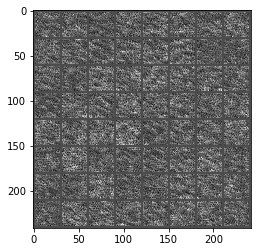

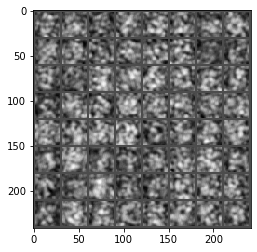

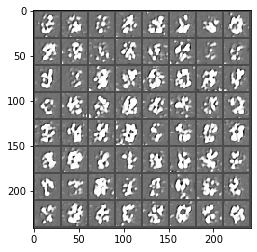

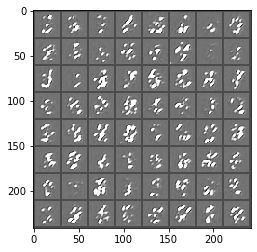

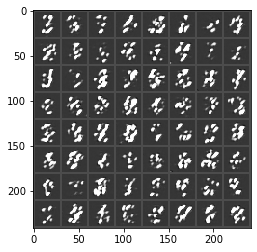

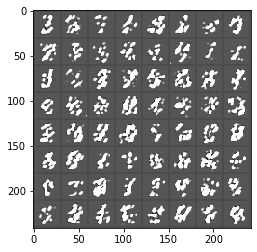

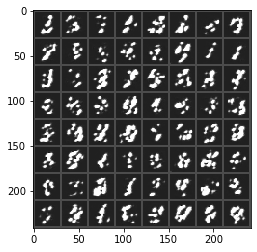

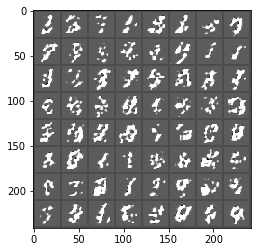

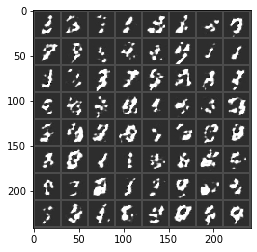

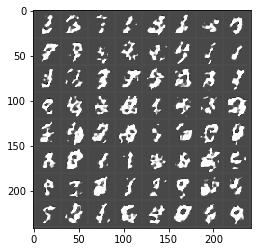

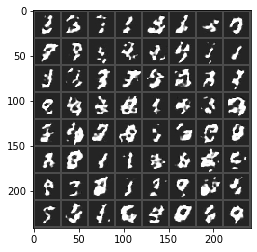

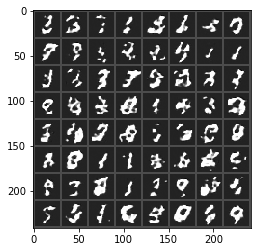

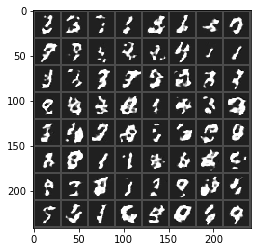

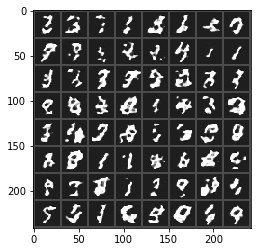

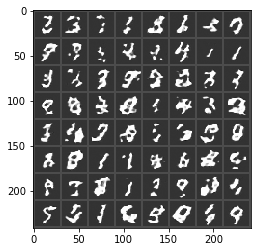

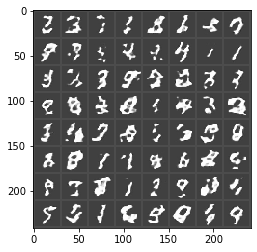

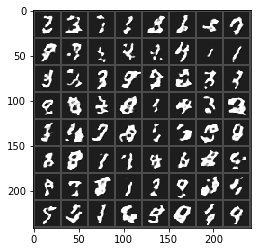

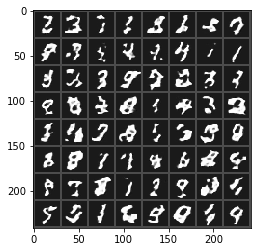

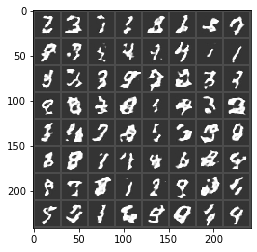

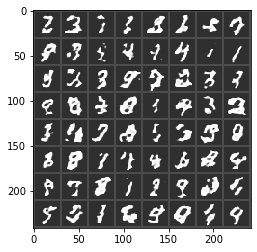

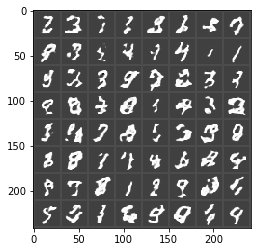

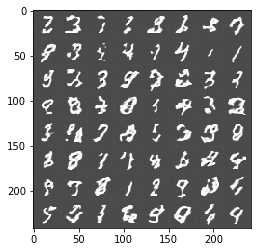

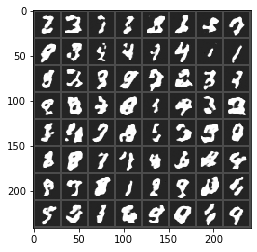

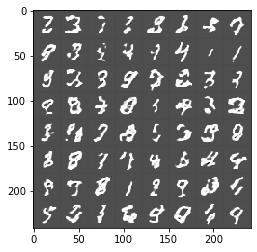

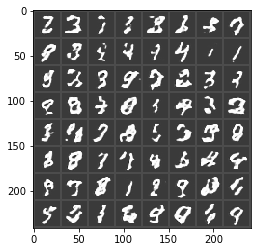

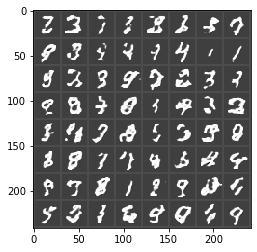

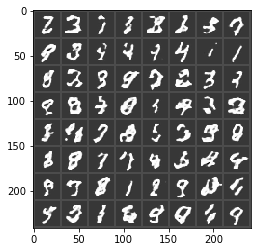

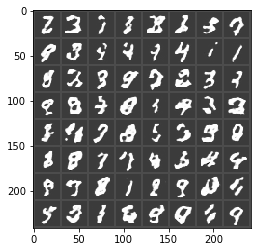

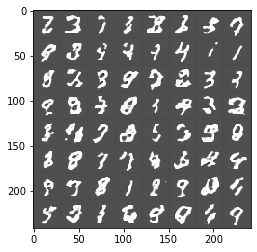

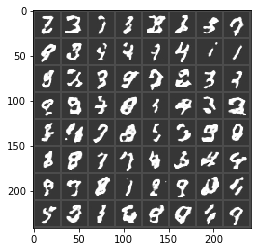

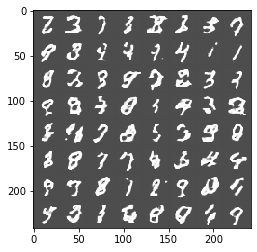

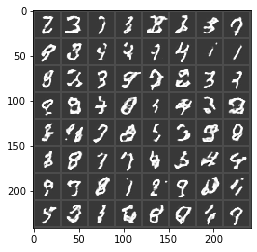

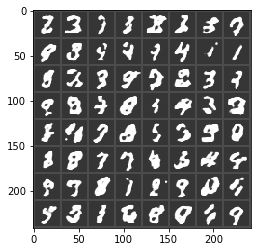

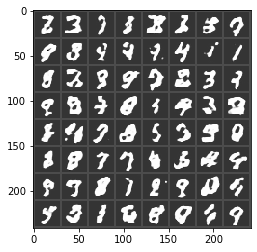

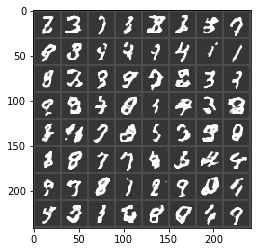

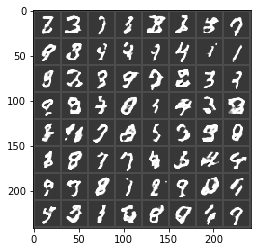

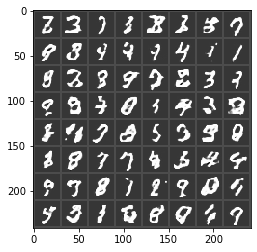

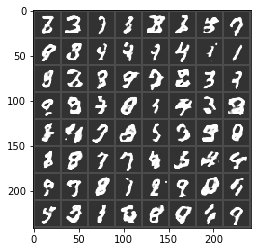

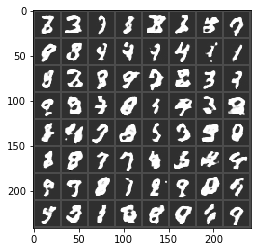

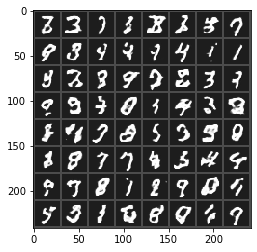

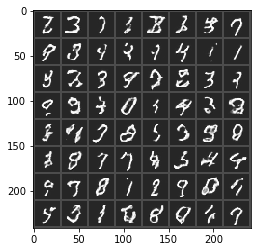

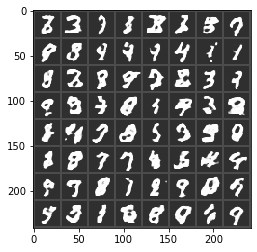

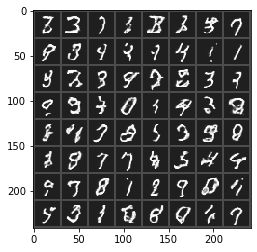

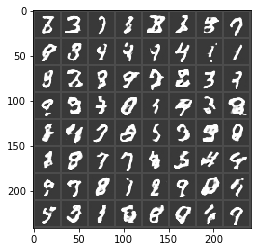

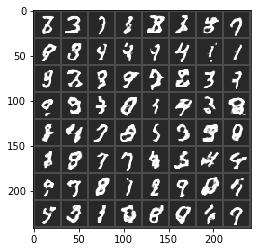

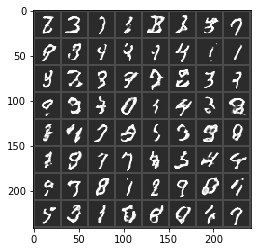

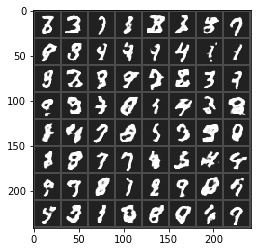

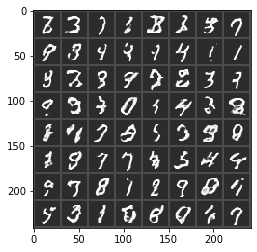

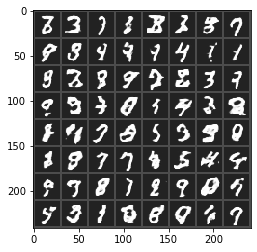

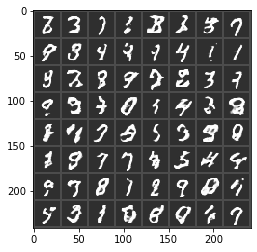

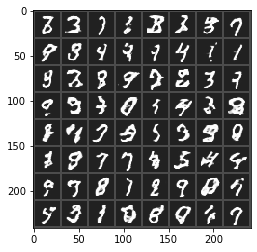

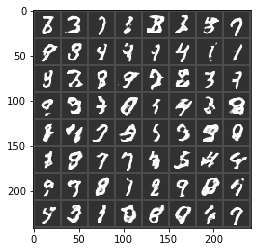

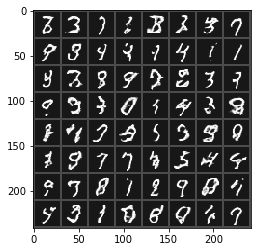

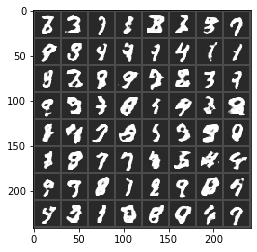

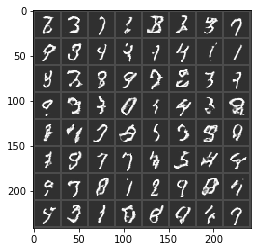

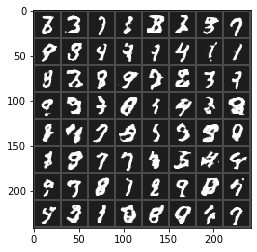

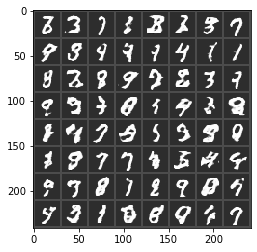

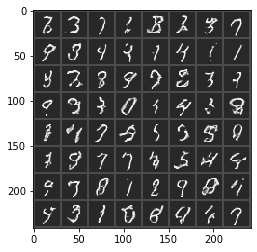

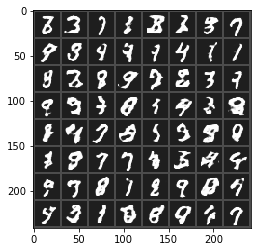

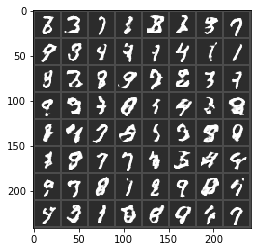

In [567]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

In [568]:
batchSize = 100
noiseDim = 100

D = Discriminator().to(device)
G = Generator().to(device)
optimizerD = torch.optim.Adam(D.parameters(), lr=2e-4)
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4)

with torch.no_grad():
    for i,x in enumerate(grids):
        G.conv4.weight[0,i,:,:] = torch.nn.Parameter(torch.tensor(x)).to(device)
    G.conv3.requires_grad = False

    for i,x in enumerate(grids):
        D.conv1.weight[i,...] = torch.nn.Parameter(torch.tensor(x)).to(device)
    D.conv1.requires_grad = False
        
        
# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, noiseDim, device=device)

for epoch in range(10): # 10 epochs
    for i in range(0, data_X.size()[0], batchSize):
        
        # STEP 1: Discriminator optimization step
        x_real = data_X[i:(i+batchSize),...].to(device)        
        optimizerD.zero_grad()
        
        lab_real = torch.ones(x_real.size()[0], 1, device=device)
        lab_fake = torch.zeros(x_real.size()[0], 1, device=device)

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(lab_fake.size()[0], noiseDim, device=device)
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)        

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        optimizerG.zero_grad()

        z = torch.randn(lab_fake.size()[0], noiseDim, device=device)
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)

        lossG.backward()
        optimizerG.step()
        if i % 10000 == 0:
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(data_X), D_x.mean().item(), D_G_z.mean().item()))
            x_gen = G(fixed_noise)
            collect_x_gen.append(x_gen.detach().clone())


e0.i0/60000 last mb D(x)=0.5167 D(G(z))=0.5387
e0.i10000/60000 last mb D(x)=0.9967 D(G(z))=0.0002
e0.i20000/60000 last mb D(x)=0.9934 D(G(z))=0.0482
e0.i30000/60000 last mb D(x)=0.8755 D(G(z))=0.1511
e0.i40000/60000 last mb D(x)=0.9024 D(G(z))=0.0787
e0.i50000/60000 last mb D(x)=0.9214 D(G(z))=0.1465
e1.i0/60000 last mb D(x)=0.9746 D(G(z))=0.0494
e1.i10000/60000 last mb D(x)=0.9466 D(G(z))=0.0832
e1.i20000/60000 last mb D(x)=0.9577 D(G(z))=0.0545
e1.i30000/60000 last mb D(x)=0.9909 D(G(z))=0.0312
e1.i40000/60000 last mb D(x)=0.9944 D(G(z))=0.0452
e1.i50000/60000 last mb D(x)=0.9655 D(G(z))=0.0231
e2.i0/60000 last mb D(x)=0.9039 D(G(z))=0.0240
e2.i10000/60000 last mb D(x)=0.9722 D(G(z))=0.0328
e2.i20000/60000 last mb D(x)=0.9493 D(G(z))=0.0486
e2.i30000/60000 last mb D(x)=0.9820 D(G(z))=0.0814
e2.i40000/60000 last mb D(x)=0.9901 D(G(z))=0.0483
e2.i50000/60000 last mb D(x)=0.9507 D(G(z))=0.0387
e3.i0/60000 last mb D(x)=0.9405 D(G(z))=0.1079
e3.i10000/60000 last mb D(x)=0.9641 D(G(z))=0.0

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


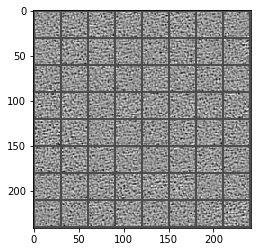

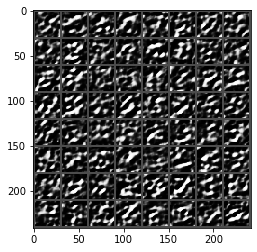

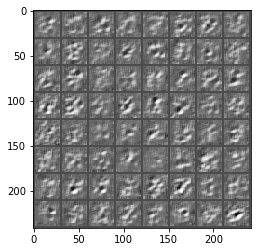

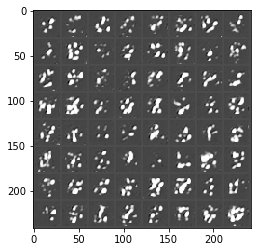

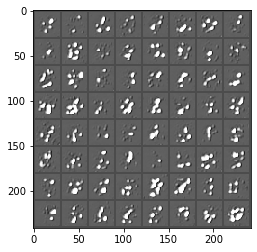

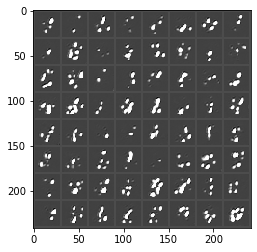

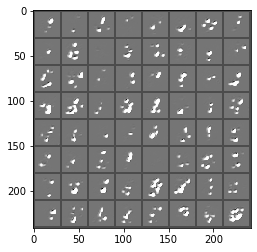

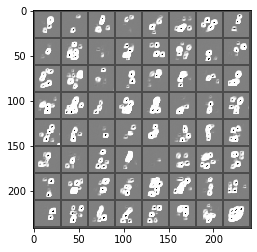

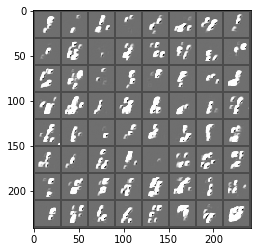

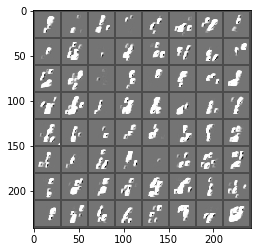

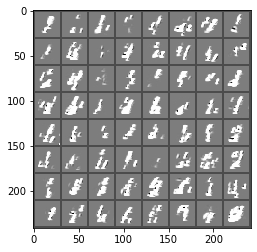

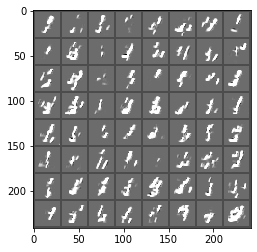

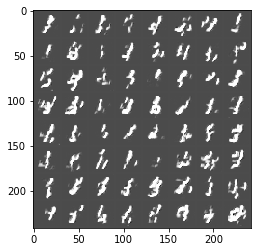

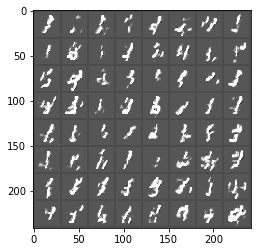

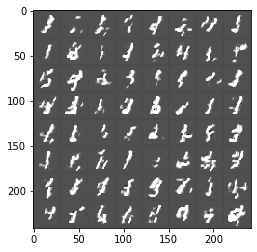

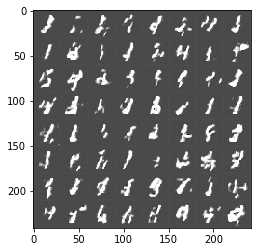

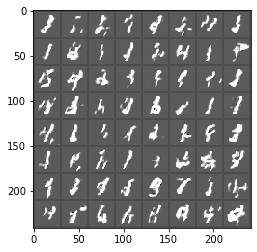

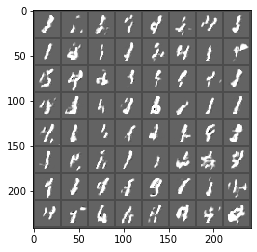

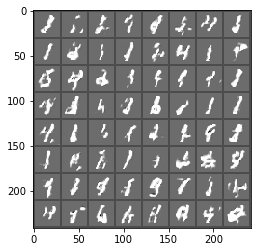

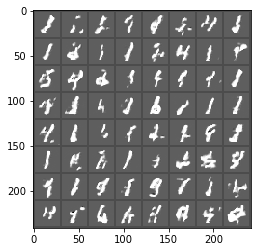

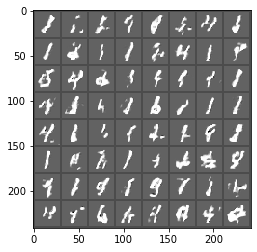

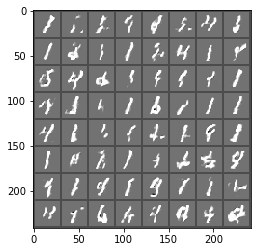

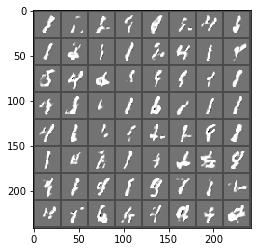

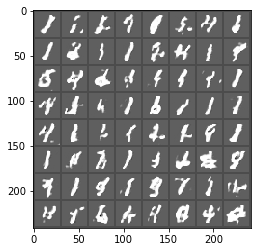

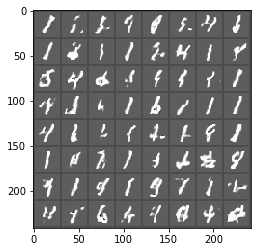

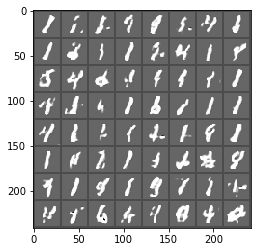

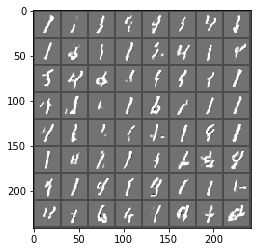

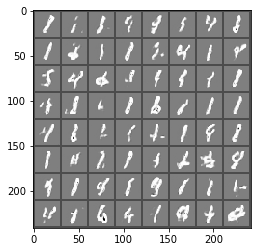

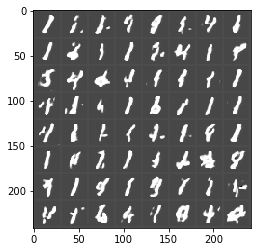

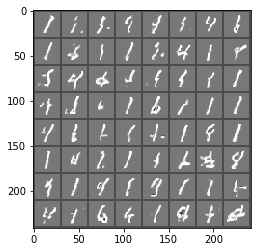

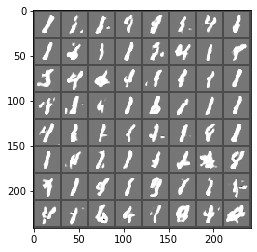

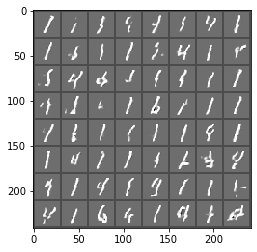

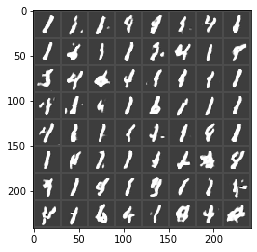

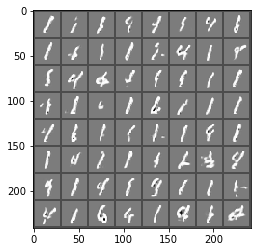

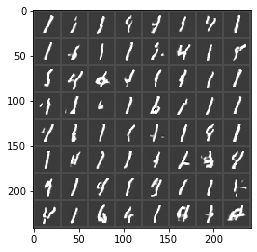

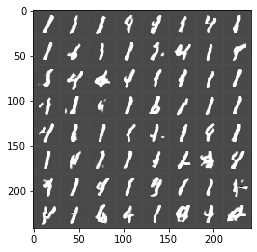

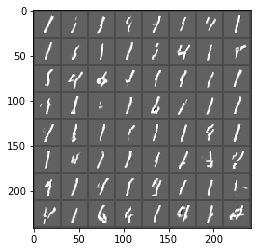

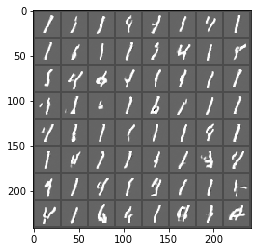

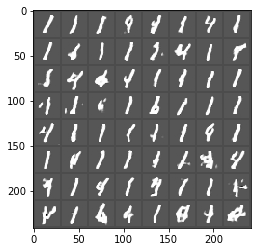

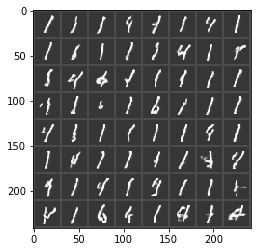

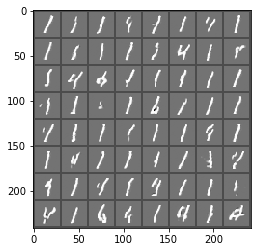

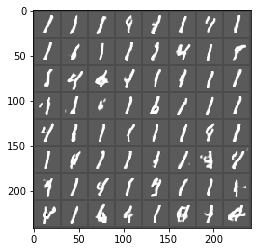

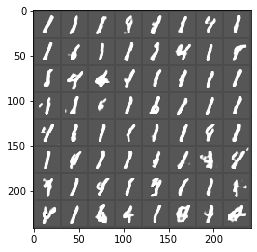

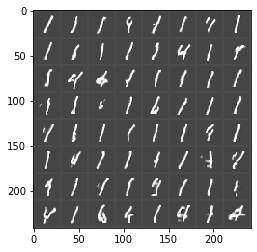

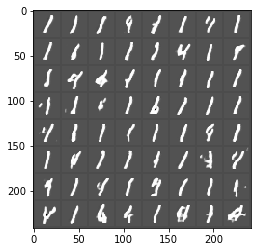

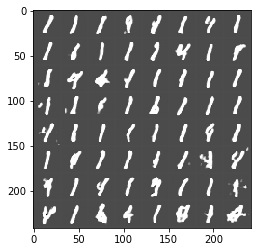

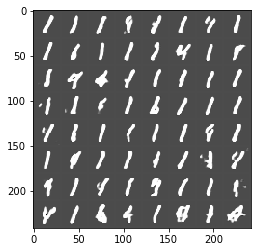

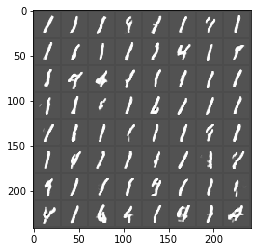

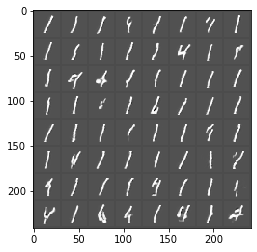

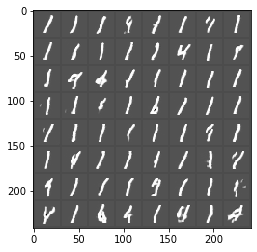

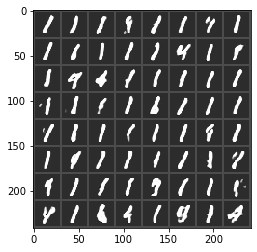

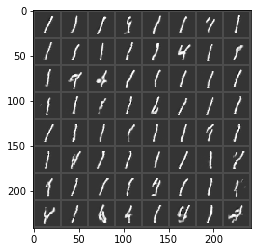

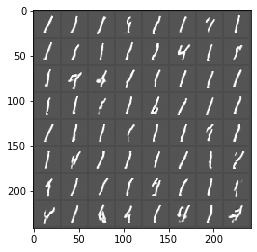

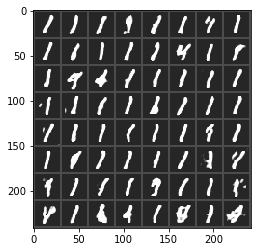

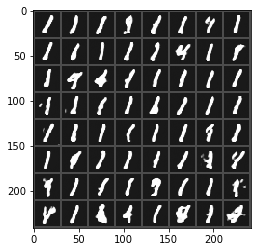

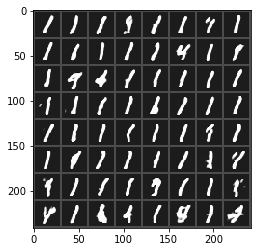

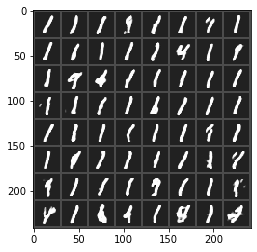

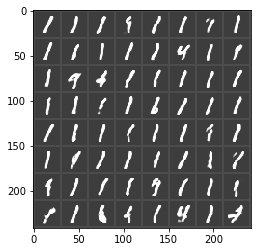

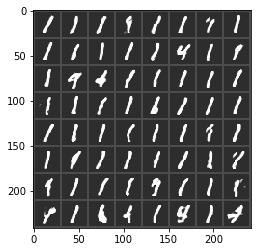

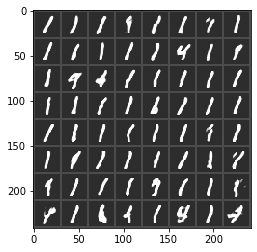

In [569]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)